
# Анализ закономерностей, определяющих успешность игр, для интернет-магазина "Стримчик" #

Из открытых источников мы получили и обработали исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Перед нами данные до 2016 года, которую содержат информацию о название игры, платформе, годе выпуска, жанре игры, продажах в Северной Америке, в Европе, в Японии и  в других странах, об оценке критиков и пользователей и о рейтинге от организации ESRB (определяющей подходящую возрастную категорию игр).

**Задача, которую мы пытаемся решить в данном исследовании, следующая:** необходимо выявить определяющие успешность игры закономерности, чтобы позволить "Стримчику" сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**На основе этих данных мы проведем исследование и построим нашу работу следующим образом:**

1. Загрузим данные и подготовим их для анализа.
2. Проанализируем показатели продаж по годам, жанрам и платформам.
3. Составим портрет пользователя из трёх регионов: Северной Америки, Европы и Японии.
4. Проверим жизнеспособность двух выдвинутых нами гипотез.

**Шаг 1: загрузка и предварительное изучение данных файла**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [3]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


По первым строкам датасета мы уже можем обнаружить проблемы, которые нужно будет исправить дальше. Например, названия столбцов не стандартизированы и не приведены к нижнему регистру. Столбец Year_of_Release приведен не к верному типу данных (float) и нужно исправить его на int. В столбцах Critic_Score, User_Score и Rating уже обнаружены пропуски. Посмотрим дальше детальнее на информацию о датасете, чтобы сделать точные выводы.

In [4]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


По результатам данной проверки можно обнаружить, что в столбце Year_of_Release и Critic_Score обнаружены пропуски. Кроме того, результаты столбца User_Score не были выведены, а это значит, что нужно пристальнее обратить на него внимание и посмотреть, где может содержаться ошибка в столбце. 

Также по результатам проверки столбцов NA_sales, EU_sales, JP_sales и Other_sales 75% значений не превышают достаточно низких показателей (не больше 0.24 млн копий), тогда как максимальные значения намного больше (вплоть до 41.36 млн), что говорит о некотором количество выбросов в данных – есть очень популярные игры, которые продавались больше всего.

По минимальным значения продаж мы можем судить о том, что были игры, которые вообще не продались (0 млн копий). 

Самая первая игра, которая была зафиксирована в датасете, была выпущена в 1980 году. Квартили же показывают, что большая часть игр была выпущена в период с 2003 по 2010 год.

Значения в столбце Critic_Score говорят нам о том, что критики оценивали игры в большей части случаях от 60 до 79 баллов, тогда как минимальная оценка, поставленная игре – 13, а максимальная - 98.

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В датасете хранятся 16715 наблюдений. Пропуски есть в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating. В столбцах User_Score данные хранятся в типе object, хотя оценка должна быть числовым значением. Обратим на это внимание и обследуем столбец. Кроме того, тип float64 в столбце Year_of_Release можно поменять на int.

In [6]:
games['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
9.6       2
1.5       2
0.3       2
9.7       1
0         1
Name: User_Score, Length: 96, dtype: int64

В столбце и правда хранятся числовые значения, однако присутствует 2424 наблюдений с записью "tbd", которые нужно исправить.

**Шаг 2: предобработка данных**

Начнём с того, что для удобства приведем все данные из датасета к нижнему регистру, чтобы также исключить возможность дубликатов.

In [7]:
games.columns = games.columns.str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
games.duplicated().sum()

0

In [9]:
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
games['genre'] = games['genre'].str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [10]:
games.duplicated().sum()

0

Дубликатов не обнаружено.

In [11]:
games['year_of_release'] = games['year_of_release'].convert_dtypes()

In [12]:
games = games.dropna(subset=['year_of_release'])

Удалим игры с пропусками в годе реализа. Их достаточно мало, поэтому удаление этих значений не повлияет на дальнейший анализ.

In [13]:
print(games[games['name'].isnull()])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      gen             1993   NaN      1.78      0.53      0.00   
14244  NaN      gen             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


В двух строчках (659, 14244) хранится информациях о двух продажах, где пропущены практически все нужные нам значения – в особенности имя и жанр, поэтому стоит исключить две эти строчки из нашего датасета без вреда на основные выводы исследования.

In [14]:
games = games.dropna(subset=['name'])

Как мы уже отмечали, в столбце user_score хранится информация неверного типа, так как присутствуют некоторые строчные значения. Заменим их на пропуски, чтобы перевести столбец в цифровой формат для удобства работы.

In [15]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan
games['user_score'] = pd.to_numeric(games['user_score'])

In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


После обработки пропусков некоторых значений, в нашем датасете остались пропуски в столбцах critic_score, user_score и rating. Посколько восстановить пропуски не предоставляется возможным, так как оценки зависят от многих факторов и могут кардинально отличаться, оставим эти пропуски как есть и будем продолжать анализ.

Посчитаем суммарную вырочку для каждой игры.

In [17]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

**Шаг 3: исследовательский анализ данных**

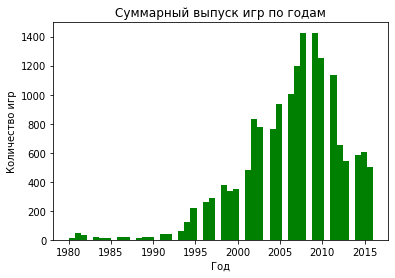

In [18]:
games[games['year_of_release'] > 0]['year_of_release'].plot(kind='hist', bins=50, color='green')
plt.title('Суммарный выпуск игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show();

По графику мы можем сделать вывод, что видеоигры начали набирать популярность в 1990-е. Пик выпуска видеоигр приходится на период с 2005 по 2010, после чего начинается спад в выпуске игр.

In [19]:
platforms = games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
platforms = platforms[platforms['total_sales'] > 700]
platforms.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.78
ps,727.58


Платформы ps2, x360, ps3, wii, ds, ps  стали самыми популярными с наибольшими суммарными продажами. Посчитаем сколько они зарабатывали за каждый интересующий нас год.

In [20]:
sales = games.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='sum')
sales = sales.query('platform in @platforms.index')
sales = sales.T
sales = sales.dropna(how='all')
sales

platform,ds,ps,ps2,ps3,wii,x360
year_of_release,,,,,,
1985,0.02,NaN,NaN,NaN,NaN,NaN
1994,NaN,6.03,NaN,NaN,NaN,NaN
1995,NaN,35.96,NaN,NaN,NaN,NaN
1996,NaN,94.70,NaN,NaN,NaN,NaN
1997,NaN,136.17,NaN,NaN,NaN,NaN
1998,NaN,169.49,NaN,NaN,NaN,NaN
1999,NaN,144.53,NaN,NaN,NaN,NaN
2000,NaN,96.37,39.17,NaN,NaN,NaN
2001,NaN,35.59,166.43,NaN,NaN,NaN


<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='year_of_release', ylabel='ds'>

Text(0.5, 1.0, 'Распределение продаж по годам платформы ds')

Text(0.5, 0, 'Год')

Text(0, 0.5, 'Количество игр')

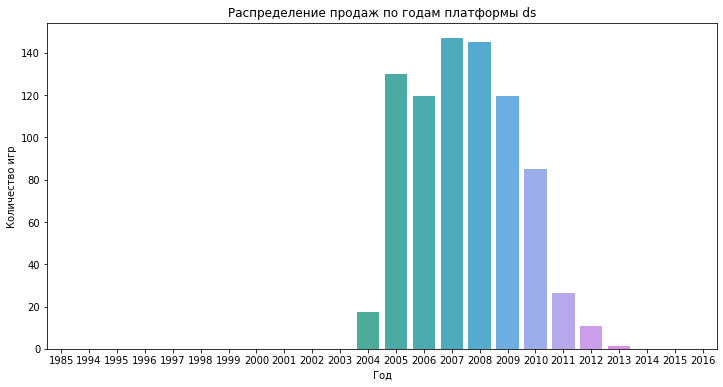

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='year_of_release', ylabel='ps'>

Text(0.5, 1.0, 'Распределение продаж по годам платформы ps')

Text(0.5, 0, 'Год')

Text(0, 0.5, 'Количество игр')

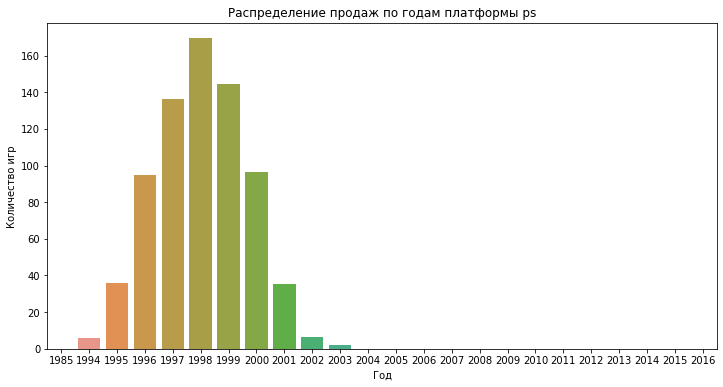

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='year_of_release', ylabel='ps2'>

Text(0.5, 1.0, 'Распределение продаж по годам платформы ps2')

Text(0.5, 0, 'Год')

Text(0, 0.5, 'Количество игр')

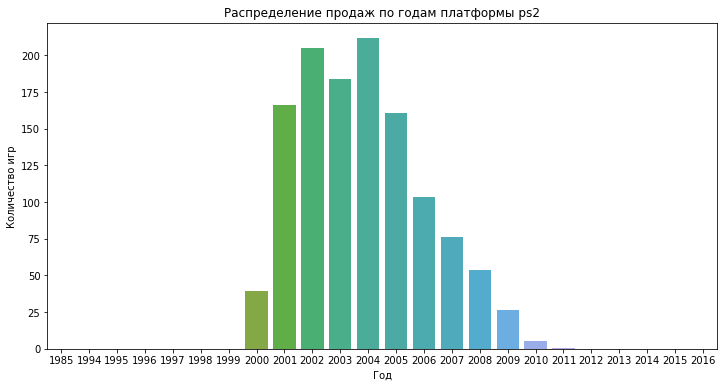

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='year_of_release', ylabel='ps3'>

Text(0.5, 1.0, 'Распределение продаж по годам платформы ps3')

Text(0.5, 0, 'Год')

Text(0, 0.5, 'Количество игр')

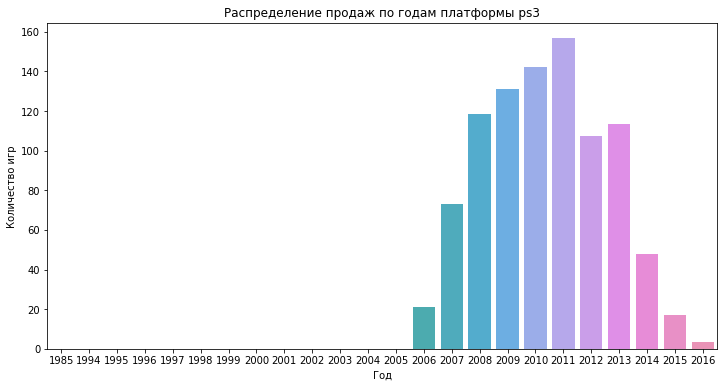

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='year_of_release', ylabel='wii'>

Text(0.5, 1.0, 'Распределение продаж по годам платформы wii')

Text(0.5, 0, 'Год')

Text(0, 0.5, 'Количество игр')

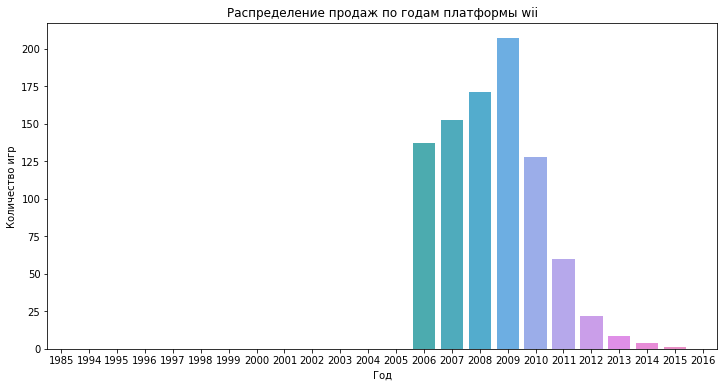

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='year_of_release', ylabel='x360'>

Text(0.5, 1.0, 'Распределение продаж по годам платформы x360')

Text(0.5, 0, 'Год')

Text(0, 0.5, 'Количество игр')

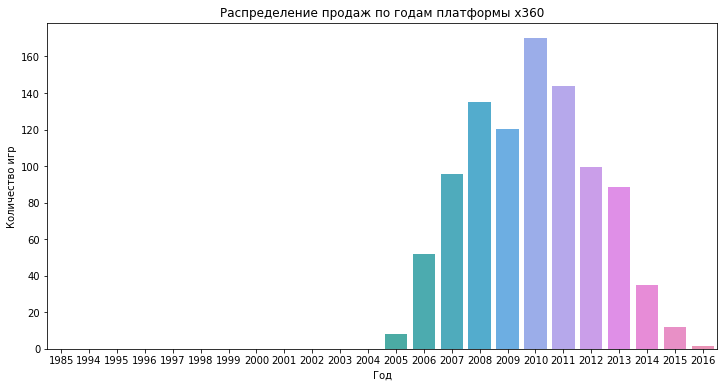

In [21]:
for i in platforms.index:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=sales.index, y=i, data=sales)
    plt.title(f'Распределение продаж по годам платформы {i}')
    plt.xlabel('Год')
    plt.ylabel('Количество игр')
    plt.show();

По проведенному нами анализу мы обнаружили, что в среднем, платформы являются жизнеспособными на протяжении 10-12 лет, однако срок, за который они развиваются, это примерно 3-4 года, поэтому в качестве актуального периода для дальнейшего анализа установим следующий период: с 2012 по 2016 год, и отсортируем значения в таблице в соответствии с этим периодом.

In [22]:
new_games = games[games['year_of_release'] > 2011]
new_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,pokemon x/pokemon y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,call of duty: black ops ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [23]:
platforms_new = new_games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
platforms_new.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
ps4,314.14
ps3,288.79
x360,236.54
3ds,194.61
xone,159.32
wiiu,82.19
pc,62.65
psv,49.18
wii,35.37


В соответствии с даннами актуального периода лидируют платформы ps4, ps3, x360, 3ds и xone. Посмотрим на распределение данных актуальных платформ по годам.

In [24]:
sales_new = new_games.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='sum')
sales_new = sales_new.T
sales_new

platform,3ds,ds,pc,ps3,ps4,psp,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


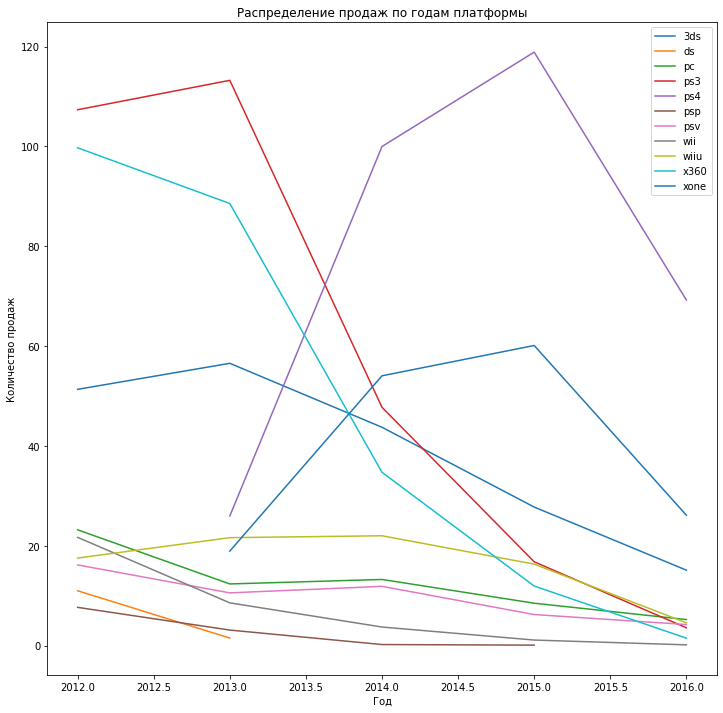

In [25]:
plt.figure(figsize=(12, 12))
plt.plot(sales_new['3ds'], label='3ds')
plt.plot(sales_new['ds'], label='ds')
plt.plot(sales_new['pc'], label='pc')
plt.plot(sales_new['ps3'], label='ps3')
plt.plot(sales_new['ps4'], label='ps4')
plt.plot(sales_new['psp'], label='psp')
plt.plot(sales_new['psv'], label='psv')
plt.plot(sales_new['wii'], label='wii')
plt.plot(sales_new['wiiu'], label='wiiu')
plt.plot(sales_new['x360'], label='x360')
plt.plot(sales_new['xone'], label='xone')
plt.legend()
plt.title(f'Распределение продаж по годам платформы')
plt.xlabel('Год')
plt.ylabel('Количество продаж')
plt.show();

Исходя из графиков мы можем сделать следующий выводы:

Продажы следующий платформ уже давно не актуальны: ds с 2013 года, psp с 2015.

Продажи платформ pc, ps3, psv, wii, wiiu, x360 идут на спад и скорее всего, основываясь на средней продолжительности жизнеспособности платформы, скоро перестанут пользоваться спросом.

Продажи платформ 3ds, ps4 и xone падают, но скорее всего они еще будут актуальны в ближайшее время, основываясь на средней продолжности жизнеспособности платформ – они стали актуальными не так давно.

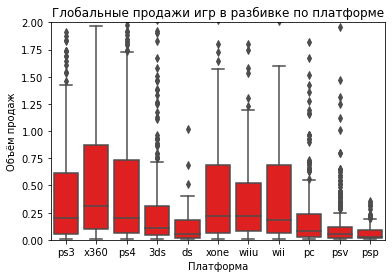

In [26]:
sns.boxplot(data=new_games, y="total_sales", x="platform", color='red')
plt.title('Глобальные продажи игр в разбивке по платформе')
plt.xlabel('Платформа')
plt.ylabel('Объём продаж')
plt.ylim(top=2, bottom=0)
plt.show();

В целом, за анализируемые годы платформы зарабатывали значительно небольшие средства от продажи отдельных игр – большая часть значений находится около нуля (от 0 до 0.75) с медианой, не превышающей 0.5 млн копий. Платформами, игры который приносят в среднем больше выручки, стали: x360, ps3, ps4, xone и wii – большая часть значений лежит в диапазоне от 0 до примерно 1.25-1.75 млн копий, что значительно превышает остальные платформы. 

Большую часть выручку им приносят лишь отдельные игры, которые пользуется большой популярностью – практически у всех платформ есть несколько выбросов, принёсших большую часть средств. Отсюда можно объяснить падение популярности отдельный платформ – по большей части они держатся на плаву за счёт отдельных игр, а не регулярной деятельности.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Рассмотрим пять платформ, где больше всего продаж и которые сильно отрываются по продажам от других платформ: ps4, ps3, x360, 3ds, xone.

Text(0.5, 1.0, 'Влияние на продажи внутри платформы ps4 отзывов критиков')

Text(0.5, 0, 'Оценка критиков')

Text(0, 0.5, 'Объёмы продаж')

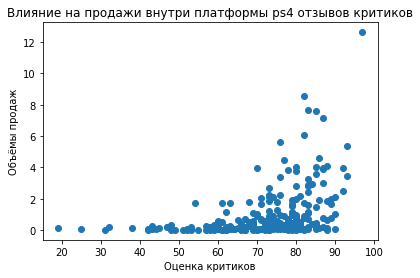

0.40656790206178095

In [27]:
games_ps4 = new_games[new_games['platform'] == 'ps4']
plt.scatter(x='critic_score', y='total_sales', data=games_ps4)
plt.title('Влияние на продажи внутри платформы ps4 отзывов критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объёмы продаж')
plt.show();
games_ps4['critic_score'].corr(games_ps4['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы ps4 отзывов пользователей')

Text(0.5, 0, 'Оценка пользователей')

Text(0, 0.5, 'Объёмы продаж')

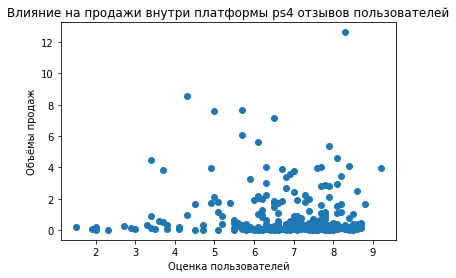

-0.031957110204556376

In [28]:
plt.scatter(x='user_score', y='total_sales', data=games_ps4)
plt.title('Влияние на продажи внутри платформы ps4 отзывов пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объёмы продаж')
plt.show();
games_ps4['user_score'].corr(games_ps4['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы ps3 отзывов критиков')

Text(0.5, 0, 'Оценка критиков')

Text(0, 0.5, 'Объёмы продаж')

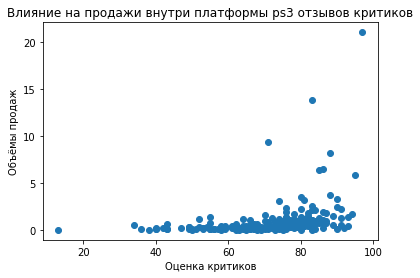

0.3314972592629587

In [29]:
games_ps3 = new_games[new_games['platform'] == 'ps3']
plt.scatter(x='critic_score', y='total_sales', data=games_ps3)
plt.title('Влияние на продажи внутри платформы ps3 отзывов критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объёмы продаж')
plt.show();
games_ps3['critic_score'].corr(games_ps3['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы ps3 отзывов пользователей')

Text(0.5, 0, 'Оценка пользователей')

Text(0, 0.5, 'Объёмы продаж')

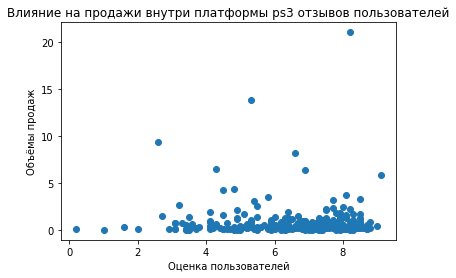

-0.005143522887113828

In [30]:
plt.scatter(x='user_score', y='total_sales', data=games_ps3)
plt.title('Влияние на продажи внутри платформы ps3 отзывов пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объёмы продаж')
plt.show();
games_ps3['user_score'].corr(games_ps3['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы 3ds отзывов критиков')

Text(0.5, 0, 'Оценка критиков')

Text(0, 0.5, 'Объёмы продаж')

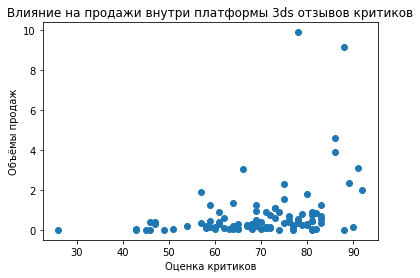

0.3208028695360785

In [31]:
games_3ds = new_games[new_games['platform'] == '3ds']
plt.scatter(x='critic_score', y='total_sales', data=games_3ds)
plt.title('Влияние на продажи внутри платформы 3ds отзывов критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объёмы продаж')
plt.show();
games_3ds['critic_score'].corr(games_3ds['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы 3ds отзывов пользователей')

Text(0.5, 0, 'Оценка пользователей')

Text(0, 0.5, 'Объёмы продаж')

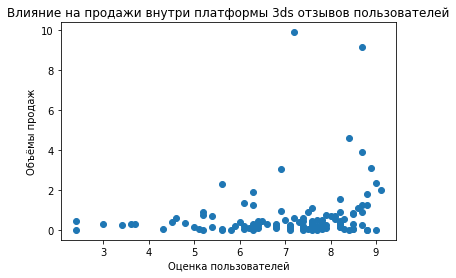

0.19758263411038599

In [32]:
plt.scatter(x='user_score', y='total_sales', data=games_3ds)
plt.title('Влияние на продажи внутри платформы 3ds отзывов пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объёмы продаж')
plt.show();
games_3ds['user_score'].corr(games_3ds['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы x360 отзывов критиков')

Text(0.5, 0, 'Оценка критиков')

Text(0, 0.5, 'Объёмы продаж')

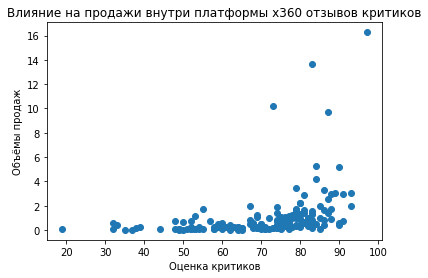

0.3605734888507336

In [33]:
games_x360 = new_games[new_games['platform'] == 'x360']
plt.scatter(x='critic_score', y='total_sales', data=games_x360)
plt.title('Влияние на продажи внутри платформы x360 отзывов критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объёмы продаж')
plt.show();
games_x360['critic_score'].corr(games_x360['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы x360 отзывов пользователей')

Text(0.5, 0, 'Оценка пользователей')

Text(0, 0.5, 'Объёмы продаж')

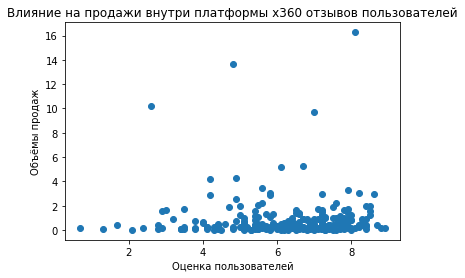

0.006163978646213326

In [34]:
plt.scatter(x='user_score', y='total_sales', data=games_x360)
plt.title('Влияние на продажи внутри платформы x360 отзывов пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объёмы продаж')
plt.show();
games_x360['user_score'].corr(games_x360['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы xone отзывов критиков')

Text(0.5, 0, 'Оценка критиков')

Text(0, 0.5, 'Объёмы продаж')

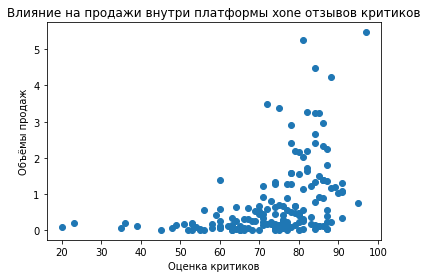

0.4169983280084017

In [35]:
games_xone = new_games[new_games['platform'] == 'xone']
plt.scatter(x='critic_score', y='total_sales', data=games_xone)
plt.title('Влияние на продажи внутри платформы xone отзывов критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объёмы продаж')
plt.show();
games_xone['critic_score'].corr(games_xone['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри платформы xone отзывов пользователей')

Text(0.5, 0, 'Оценка пользователей')

Text(0, 0.5, 'Объёмы продаж')

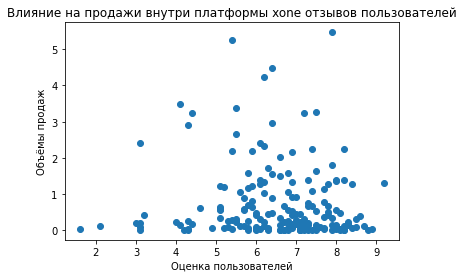

-0.06892505328279414

In [36]:
plt.scatter(x='user_score', y='total_sales', data=games_xone)
plt.title('Влияние на продажи внутри платформы xone отзывов пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объёмы продаж')
plt.show();
games_xone['user_score'].corr(games_xone['total_sales'])

Теперь посмотрим на то, как влияют на продажи внутри остальных платформ отзывы пользователей и критиков.

In [37]:
platforms_second = platforms_new[platforms_new['total_sales'] > 100]
platforms_second.sort_values(by='total_sales', ascending=False)
bad_games = new_games.query('platform not in @platforms_second.index')

,total_sales
platform,
ps4,314.14
ps3,288.79
x360,236.54
3ds,194.61
xone,159.32


Text(0.5, 1.0, 'Влияние на продажи внутри прочих платформ отзывов критиков')

Text(0.5, 0, 'Оценка критиков')

Text(0, 0.5, 'Объёмы продаж')

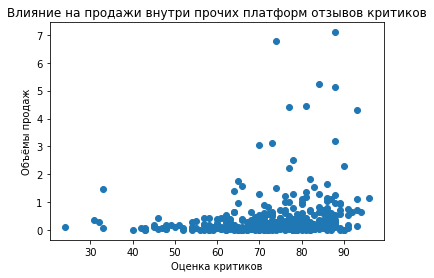

0.19950757323138532

In [38]:
plt.scatter(x='critic_score', y='total_sales', data=bad_games)
plt.title('Влияние на продажи внутри прочих платформ отзывов критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объёмы продаж')
plt.show();
bad_games['critic_score'].corr(bad_games['total_sales'])

Text(0.5, 1.0, 'Влияние на продажи внутри прочих платформы отзывов пользователей')

Text(0.5, 0, 'Оценка пользователей')

Text(0, 0.5, 'Объёмы продаж')

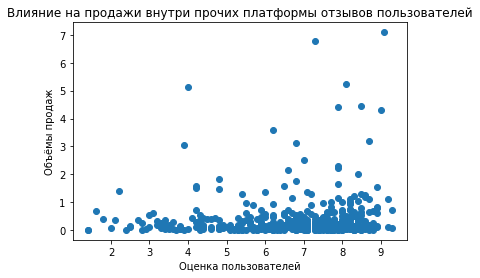

0.07672588258303085

In [39]:
plt.scatter(x='user_score', y='total_sales', data=bad_games)
plt.title('Влияние на продажи внутри прочих платформы отзывов пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объёмы продаж')
plt.show();
bad_games['user_score'].corr(bad_games['total_sales'])

По результатам графиков можно сделать следующий вывод: для большинства платформ действительно прослеживается неболшая корреляция оценок критиков и продаж. Однако оценки пользователей практически не влияют на продажи – значения корреляций иногда даже показывают отрицательное влияние оценок пользователей на продажи (например, для платформ xone, ps3, ps4).

In [40]:
genres = new_games.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'mean', 'median'])
#genres.sort_values(by='total_sales', ascending=False)
genres

,sum,mean,median
,total_sales,total_sales,total_sales
genre,,,
action,441.12,0.427856,0.120
adventure,29.43,0.097450,0.030
fighting,44.49,0.408165,0.130
misc,85.04,0.442917,0.120
platform,61.00,0.717647,0.210
puzzle,4.89,0.174643,0.045
racing,53.50,0.465217,0.140
role-playing,192.80,0.521081,0.140


Топ-5 самых продаваемых жанров игр по общим продажам следующий: action, shooter, role-playing, sports и misc. Однако игры жанра action сильно впереди даже от второго места, поэтому этот жанр сильно выделяется. Игры жанров puzzle и strategy оказались самыми малопродаваемыми.

Средние и медианные же значения продаж очень сильно отличаются: медиана везде намного меньше среднего значения, что говорит о том, что большая часть приносимой платформам выручки получается от очень популярных игр, являющихся выбросами. 

По продажам на одну игру (и медианному, и среднему значению) мы можем сделать вывод о том, что игры жанра shooter приносят больше выручки, чем остальные жанры.

**Шаг 4: составляем портрет пользователя каждого региона**

In [41]:
platforms_na = new_games.pivot_table(index='platform', values='na_sales', aggfunc='sum')
platforms_na.sort_values(by='na_sales', ascending=False).head(5)

,na_sales
platform,
x360,140.05
ps4,108.74
ps3,103.38
xone,93.12
3ds,55.31


In [42]:
platforms_eu = new_games.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
platforms_eu.sort_values(by='eu_sales', ascending=False).head(5)

,eu_sales
platform,
ps4,141.09
ps3,106.86
x360,74.52
xone,51.59
3ds,42.64


In [43]:
platforms_jp = new_games.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
platforms_jp.sort_values(by='jp_sales', ascending=False).head(5)

,jp_sales
platform,
3ds,87.79
ps3,35.29
psv,21.04
ps4,15.96
wiiu,13.01


Общий портрет продаж игр по платформам в Северной Америке и Европе достаточно похож: в топ-5 вошёл одинаковый набор платформ. Единственное отличие в первом месте: для Северной Америки это x360, для Европы – ps4, 

Портрет Японии же немного отличается от предыдущих расмотренных нами. В Японии также в топе присутствуют платформы psv и wiiu, а самой популярной выступает платформа 3ds, которая в Европе и Северной Америке заняла лишь 5 место.

In [44]:
genres_na = new_games.pivot_table(index='genre', values='na_sales', aggfunc='sum')
genres_na.sort_values(by='na_sales', ascending=False).head(5)

,na_sales
genre,
action,177.84
shooter,144.77
sports,81.53
role-playing,64.00
misc,38.19


In [45]:
genres_eu = new_games.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
genres_eu.sort_values(by='eu_sales', ascending=False).head(5)

,eu_sales
genre,
action,159.34
shooter,113.47
sports,69.09
role-playing,48.53
racing,27.29


In [46]:
genres_jp = new_games.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
genres_jp.sort_values(by='jp_sales', ascending=False).head(5)

,jp_sales
genre,
role-playing,65.44
action,52.80
misc,12.86
simulation,10.41
fighting,9.44


Общий портрет продаж игр по жанрам в Северной Америке и Европе достаточно похож: в топ-4 вошёл одинаковый набор платформ. Единственное отличие в 5 месте: жанры role-playing и misc. Первая отсутствует в Европе, вторая же наоборот присутствует. 

Портрет Японии же немного отличается от предыдущих расмотренных нами. В Японии также в топе присутствует жанры simulation и fighting, а самым популярным выступает жанр role-playing, который присутствовал лишь в Европе и Северной Америке на 4 месте.

In [47]:
rating_na = new_games.pivot_table(index='rating', values='na_sales', aggfunc='sum')
rating_na.sort_values(by='na_sales', ascending=False)

,na_sales
rating,
M,231.57
E,114.37
E10+,75.70
T,66.02


In [48]:
rating_eu = new_games.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
rating_eu.sort_values(by='eu_sales', ascending=False)

,eu_sales
rating,
M,193.96
E,113.03
E10+,55.37
T,52.96


In [49]:
rating_jp = new_games.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
rating_jp.sort_values(by='jp_sales', ascending=False)

,jp_sales
rating,
E,28.33
T,26.02
M,21.20
E10+,8.19


Для Европы и Северной Америки рейтинг распределения игр по рейтигам оказался одинаковым: самым популярным рейтингом стал М. ДЛя Японии же рейтинг М оказался только на 3 месте, тогда как самым популярным стал рейтинг Е.

**Портрет пользователя из Северной Америки**

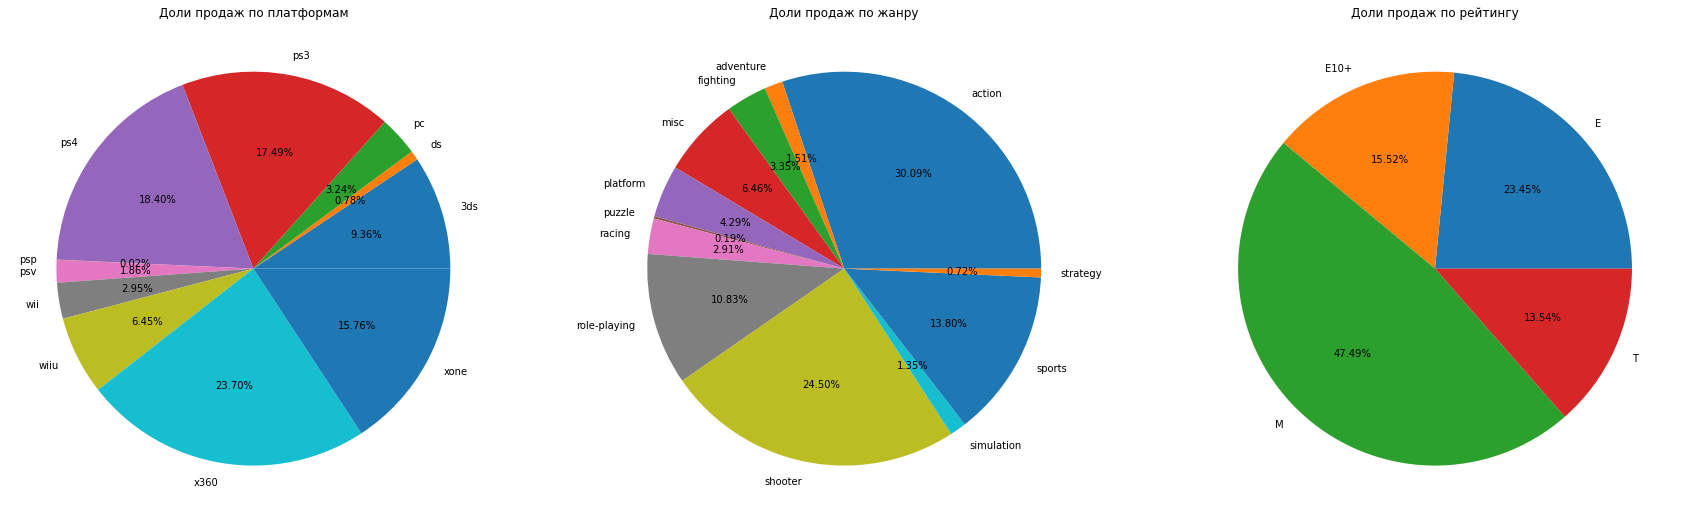

In [50]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.pie(platforms_na['na_sales'], labels=platforms_na.index, autopct='%1.2f%%')
plt.title('Доли продаж по платформам')
plt.subplot(1, 3, 2)
plt.pie(genres_na['na_sales'], labels=genres_na.index, autopct='%1.2f%%')
plt.title('Доли продаж по жанру')
plt.subplot(1, 3, 3)
plt.pie(rating_na['na_sales'], labels=rating_na.index, autopct='%1.2f%%')
plt.title('Доли продаж по рейтингу')
plt.show();

**Портрет пользователя из Европы**

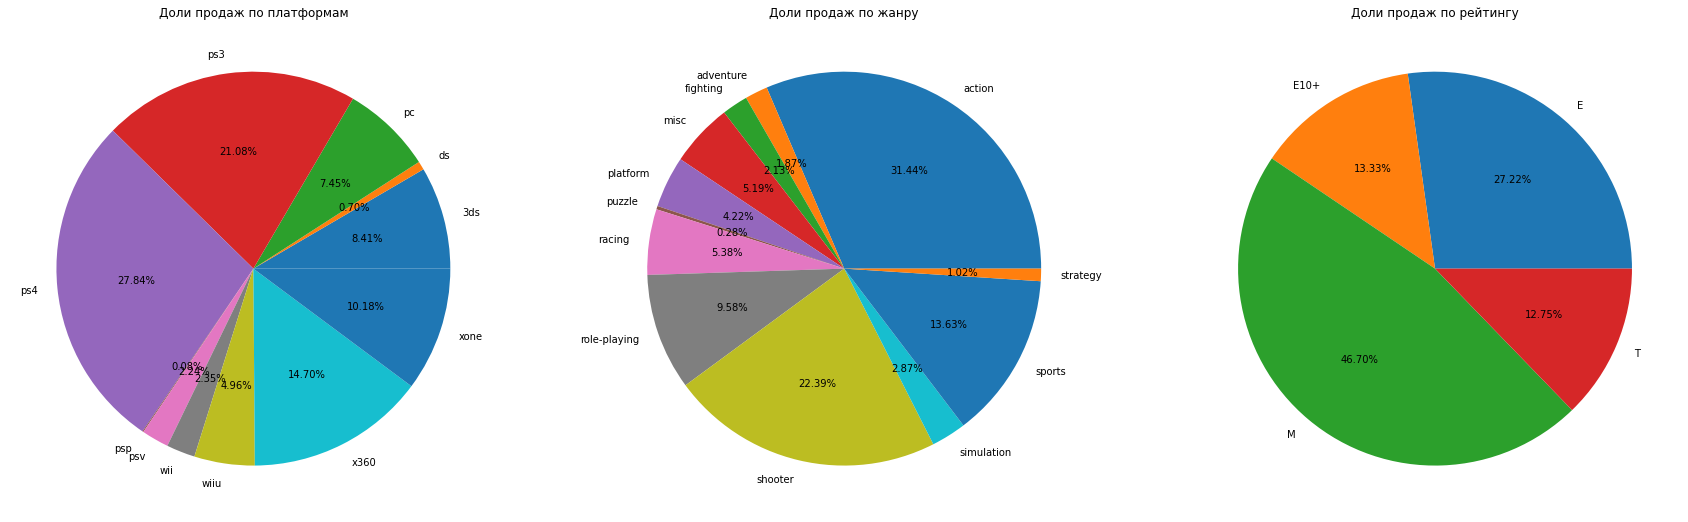

In [51]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.pie(platforms_eu['eu_sales'], labels=platforms_eu.index, autopct='%1.2f%%')
plt.title('Доли продаж по платформам')
plt.subplot(1, 3, 2)
plt.pie(genres_eu['eu_sales'], labels=genres_eu.index, autopct='%1.2f%%')
plt.title('Доли продаж по жанру')
plt.subplot(1, 3, 3)
plt.pie(rating_eu['eu_sales'], labels=rating_eu.index, autopct='%1.2f%%')
plt.title('Доли продаж по рейтингу')
plt.show();

**Портрет пользователя из Японии**

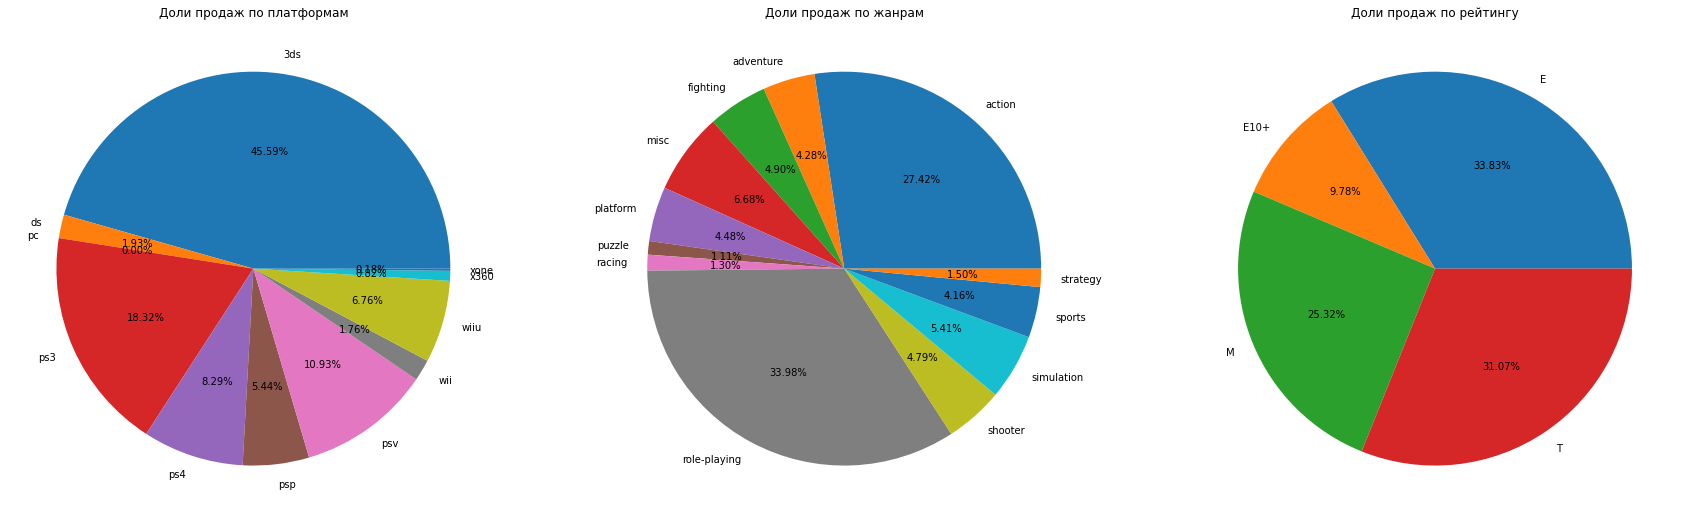

In [52]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.pie(platforms_jp['jp_sales'], labels=platforms_jp.index, autopct='%1.2f%%')
plt.title('Доли продаж по платформам')
plt.subplot(1, 3, 2)
plt.pie(genres_jp['jp_sales'], labels=genres_jp.index, autopct='%1.2f%%')
plt.title('Доли продаж по жанрам')
plt.subplot(1, 3, 3)
plt.pie(rating_jp['jp_sales'], labels=rating_jp.index, autopct='%1.2f%%')
plt.title('Доли продаж по рейтингу')
plt.show();

**Шаг 5: проверка гипотез**

**Теперь проверим гипотезы о том, что:**

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

Применим правосторонний критерий для проверки первой гипотезы, чтобы выяснить, у каких платформ большие средние оценки пользователей и двухсторонний критерий, чтобы проверить равенства средних оценок пользователей у двух жанров,

**Проверка первой гипотезы**

Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Н1: Средний пользовательские рейтинг платформы Xbox One отличается от среднего пользовательского рейтинга платформы PC.

In [53]:
good_games = new_games.dropna(subset=['user_score'])

In [54]:
alpha = 0.05

results = st.ttest_ind(good_games[good_games['platform'] == 'xone']['user_score'], 
                       good_games[good_games['platform'] == 'pc']['user_score'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 0.5535080500643661
Нет оснований отвергнуть нулевую гипотезу


По результатам теста мы не можем отвергнуть нулевую гипотезу о равенстве, следовательно, средние пользовательские рейтинги платформ Xbox One и PC с большей вероятностью одинаковые.

**Проверка второй гипотезы**

Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Н1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [55]:
alpha = 0.05

results = st.ttest_ind(good_games[good_games['genre'] == 'action']['user_score'], 
                       good_games[good_games['genre'] == 'sports']['user_score'])

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


По результатам теста мы можем отвергнуть нулевую гипотезу о равенстве и сказать о том, что с большей вероятностью средние пользовательские рейтинги жанров Action и Sports разные. Проверим, больше или меньше.

In [56]:
alpha = 0.05

results = st.ttest_ind(good_games[good_games['genre'] == 'action']['user_score'], 
                       good_games[good_games['genre'] == 'sports']['user_score'], alternative='greater')

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8581544730467437e-26
Отвергаем нулевую гипотезу


По результатам теста мы выяснили, что средний пользовательский рейтинг жанра Action с большей вероятностью больше, чем средний пользовательский рейтинг жанра Sports.

**Шаг 6: общие выводы**

В данном исследовании мы проанализировали данные и проверили некоторые гипотезы, которые могут помочь бизнесу вырасти и решить, на какой потенциально популярный продукт делать ставку, чтобы спланировать рекламные кампании.

**Основываясь на данных полученных из датасета, содержащих детальную информацию о каждой игре, ее жанра, платформе, годе выпуска, рейтинга и продажах, мы предприняли следующие шаги:**
1. Провели исследовательский анализ данных, чтобы определить сколько игр выпускалось в разные годы, определили актуальный период для анализа, нашли самые популярные платформы и их продажи за актуальный период.
2. Определили, какие платформы и жанры пользовались популярностью и игры каких категорий продавались больше всего.
3. Выяснили, есть ли корреляция между оценками пользователей и критиков и продаваемостью игр.
4. Определили разницу в продаваемости игр по платформам, жанрам и рейтингам у пользователей трёх регионов: Японии, Северной Америки и Европы, и какую долю от общих продаж они составляют.
5. Вывели гипотезы и протестировали их, чтобы ответить на следующие поставленные вопросы: а) отличаются ли средние пользовательские рейтинги платформ Xbox One и PC; б) отличаются ли средние пользовательские рейтинги Action и Sports.

**Проанализировав данные, можно сделать следующие выводы:**
1. Видеоигры стали набирать популярность с 1990-го года, но больше всего игр было продано в диапазоне с 2005 по 2010 год, после чего продуваемость видеоигр пошла на спад.
2. Платформы ps2, x360, ps3, wii, ds, ps стали самыми популярными с наибольшими суммарными продажами. Большую популярность имеет платформа ps2.
3. Средняя продолжительность жизнеспособности игровой платформы – 10-12 лет. Средний пик популярности платформы – 3-4 года.
4. Среди игр в актуальном периоде (установленный нами как 2012-2016 года) самыми популярными платформами стали ps4, ps3, x360, 3ds и xone
5. Самыми перспективными платформами стали 3ds, ps4 и xone. 
6. Большую часть выручку платформам приносят лишь отдельные игры, которые пользуется большой популярностью – практически у всех платформ есть несколько выбросов, принёсших большую часть средств. 
7. Оценка критиков положительно влияет на продаваемость большинства игр, тогда как оценка пользователей скорее не влияет.
8. Топ-5 самых продаваемых жанров игр следующий: action, shooter, role-playing, sports и misc. Однако в среднем, отдельно взятая игра жанра shooter приносит больше средств.
9. Портрет пользователя Северной Америки, определяющий успех: игра жанра action на платформе x360 рейтинга М.
10. Портрет пользователя Европы, определяющий успех: игра жанра action на платформе ps4 рейтинга M.
11. Портрет пользователя Японии, определяющий успех: игра жанра role-playing на платформе 3ds рейтинга E.
12. Средний пользовательский рейтинг платформы Xbox One с большей вероятностью равен среднему пользовательскому рейтинга платформы PC.
13. Средние пользовательские рейтинги жанров Action и Sports разные – средний пользовательский рейтинг жанра Action больше, чем средний пользовательский рейтинг жанра Sports.

Интернет-магазину «Стримчик» стоит делать ставку на платформы, которые совсем недавно (не позднее 5-6 лет назад) пришли на рынок и не успели «надоесть» пользователями (например, 3ds, ps4 и xone). Кроме того, необходимо определить целевую аудиторию и их регион: от этого будет зависеть то, жанры какой игры стоит продвигать. Однако, стоит сделать ставку на жанр Action, так как у него большая целевая аудитория — и в Европе, и в Северной Америке.

В дальнейшем можно продолжить исследование и проанализировать, какие распределение популярности отдельных жанров по годам, чтобы определить общие тренды их изменяемости и выяснить, на что делать ставку.